In [47]:
import pyod as od
from matplotlib import pyplot
from pyod.models.knn import KNN  # kNN detector
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


Text(0.5, 0, 'Z Label')

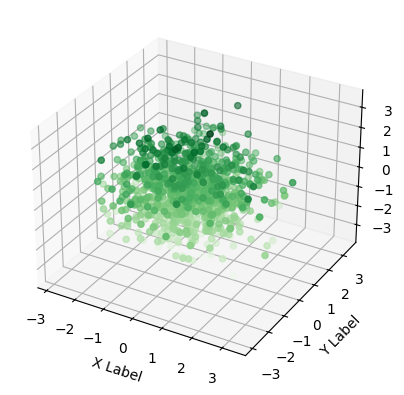

In [48]:
# sample 3d multivariate
from matplotlib import pyplot as plt
# generate data
import numpy as np
rng = np.random.default_rng()
data_3d = rng.multivariate_normal([0,0,0], [[1,0,0],[0,1,0],[0,0,1]], 1000)
x, y, z = data_3d.T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(x, y, z, c=z, cmap='Greens')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

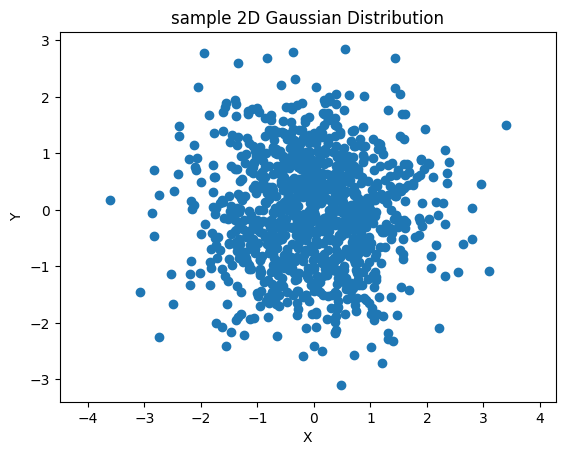

In [49]:
# sample 2d multivariate
from matplotlib import pyplot as plt
# generate data
import numpy as np
mean = [0, 0]
cov = [[1, 0], [0, 1]]
n_samples = 1000
rng = np.random.default_rng()
data_3d = rng.multivariate_normal(mean, cov, n_samples)
x, y = data_3d.T
plt.scatter(x, y)
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('sample 2D Gaussian Distribution')
plt.show()


In [50]:
import math
import pprint
import numpy as np


# https://en.wikipedia.org/wiki/Cholesky_decomposition#The_Cholesky%E2%80%93Banachiewicz_and_Cholesky%E2%80%93Crout_algorithms
def cholesky_decomp(matrix: np.ndarray) -> np.ndarray:
    n = matrix.shape[0]
    lower = np.zeros_like(matrix)
    for i in range(n):
        for j in range(i + 1):
            sum = np.dot(lower[i, :j], lower[j, :j])
            if i == j:
                lower[i, i] = math.sqrt(matrix[i, i] - sum)
            else:
                lower[i, j] = (matrix[i, j] - sum) / lower[j, j]
    return lower


# tbh it's difficult for me to conceptualize the dot product version


def cholesky_decomp_indices(matrix: np.ndarray) -> np.ndarray:
    n = matrix.shape[0]
    lower = np.zeros_like(matrix)
    for i in range(n):
        for j in range(i + 1):
            sum = 0.0
            for k in range(j):
                sum += lower[i, k] * lower[j, k]
            if i == j:
                lower[i, i] = math.sqrt(matrix[i, i] - sum)
            else:
                lower[i, j] = (matrix[i, j] - sum) / lower[j, j]
    return lower

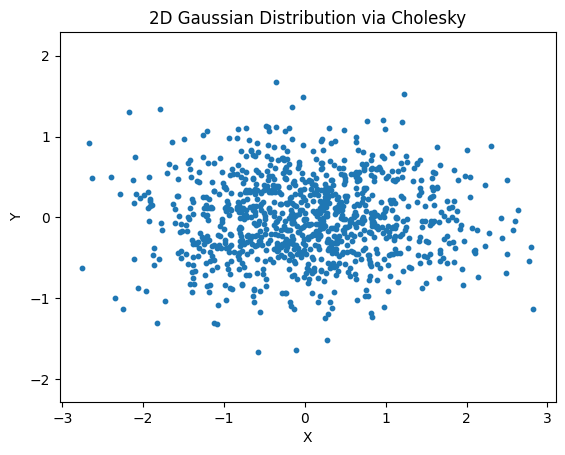

In [51]:
# doing it by hand

mean = [0, 0]
cov = [[1, 0], [0, 0.25]]
n_samples = 1000

cholesky_lower = cholesky_decomp(np.array(cov))
cholesky_lower_indices = cholesky_decomp_indices(np.array(cov))
assert np.allclose(cholesky_lower, cholesky_lower_indices)

# y = Lx + mu
rng = np.random.default_rng()
x = rng.normal(size=(n_samples, 2))
y = x @ cholesky_lower.T + mean
plt.scatter(y[:, 0], y[:, 1], s=10)
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Gaussian Distribution via Cholesky')
plt.show()

In [52]:
# Compute Mahalanobis distances for anomaly detection
import numpy as np
from scipy.spatial import distance

# y: (n_samples, n_features), mean: (n_features,), cov: (n_features, n_features)
mean_vec = np.array(mean)
cov_matrix = np.array(cov)
cov_inv = np.linalg.inv(cov_matrix)

mahalanobis_distances = np.array([
    np.sqrt((sample - mean_vec).T @ cov_inv @ (sample - mean_vec))
    for sample in y
])

# Set threshold for top 10% anomalies
contamination_rate = 0.1
threshold = np.quantile(mahalanobis_distances, 1 - contamination_rate)
anomaly_pred = mahalanobis_distances > threshold

print(f"Mahalanobis threshold for top {int(contamination_rate*100)}%: {threshold:.3f}")
print(f"Number of anomalies detected: {np.sum(anomaly_pred)}")

Mahalanobis threshold for top 10%: 2.108
Number of anomalies detected: 100


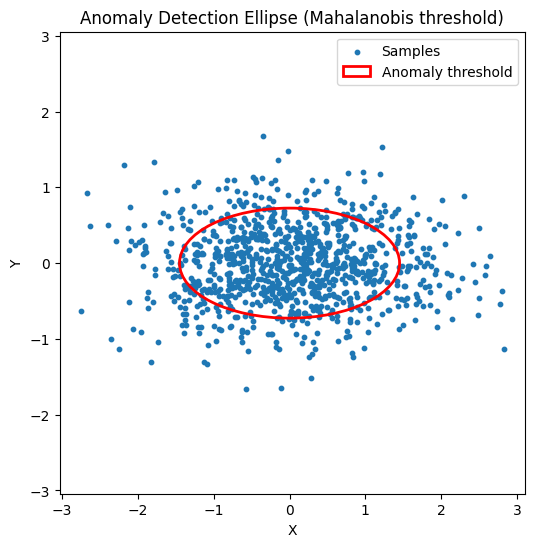

In [53]:
# extra - plot the anomaly detection ellipse and data points
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y[:, 0], y[:, 1], s=10, label='Samples')

# Compute ellipse parameters from covariance
lambda_, v = np.linalg.eigh(cov_matrix)
order = lambda_.argsort()[::-1]
lambda_ = lambda_[order]
v = v[:, order]

width, height = 2 * np.sqrt(lambda_ * threshold)
angle = np.degrees(np.arctan2(v[1, 0], v[0, 0]))

ellipse = Ellipse(mean_vec, width, height, angle=angle, edgecolor='r', facecolor='none', lw=2, label='Anomaly threshold')
ax.add_patch(ellipse)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Anomaly Detection Ellipse (Mahalanobis threshold)')
ax.legend()
plt.axis('equal')
plt.show()